In [12]:
"""Plotting of emnist results"""

import argparse
import multiprocessing
import collections
import subprocess
import pathlib
import openset_imagenet
import os, sys
import torch
import numpy
from loguru import logger
import numpy as np

from pathlib import Path
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import ticker
from matplotlib.lines import Line2D
from matplotlib.ticker import LogLocator, NullFormatter
from matplotlib import colors
import matplotlib.cm as cm


from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

from collections import defaultdict

from matplotlib import pyplot, cm, colors
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator, LogLocator
from openset_imagenet.script.parameter_selection import THRESHOLDS

In [13]:
LOSSES = ["bce", "softmax"]
ALGORITHMS = ["threshold", "binary_ensemble_emnist"]
EVALUATION_METRICS = ["baseline", "threshold", "logits"]
WHICH = "best"
FPR_THRESHOLDS = [1e-3, 1e-2, 1e-1, 1.]
OUTPUT_PATH = "dev_experiments/EMNIST/evaluation_metrics"

# create a dictionary to store the config above
args = {
    "losses": LOSSES,
    "algorithms": ALGORITHMS,
    "evaluation_metrics": EVALUATION_METRICS,
    "which": WHICH,
    "fpr_thresholds": FPR_THRESHOLDS,
    "output_path": OUTPUT_PATH
}

In [14]:
def load_scores(args):
    # collect all result files;
    suffix = args["which"]
    # we sort them as follows: protocol, loss, algorithm
    scores = defaultdict(lambda: defaultdict(dict))
    ground_truths = {}
    # load all scores from files given in args.filepaths
    for evaluation_metric in args["evaluation_metrics"]:
        for loss in args["losses"]:
            for algorithm in args["algorithms"]:
                output_directory = pathlib.Path(args["output_path"])
                alg = algorithm
                scr = "scores"
                score_file = output_directory / f"{evaluation_metric}_{loss}_{alg}_test_arr_{suffix}.npz"

                if os.path.exists(score_file):
                    # remember files
                    results = numpy.load(score_file)

                    scores[evaluation_metric][loss][algorithm] = results[scr]

                    if len(ground_truths) > 0: # check if ground truth is consistent across all files
                        assert numpy.all(results["gt"] == ground_truths["gt"])
                    else:
                        ground_truths["gt"] = results["gt"].astype(int)

                    print(f"Loaded score file {score_file} for evaluation_metric {evaluation_metric}, {loss}, {algorithm}")
                else:
                    print(f"Did not find score file {score_file} for evaluation_metric {evaluation_metric}, {loss}, {algorithm}")

    return scores, ground_truths

In [15]:
def plot_single_oscr(fpr, ccr, ax, loss, algorithm, scale, line_style=None, color=None):
    linewidth = 1.1
    if scale == 'log':
        ax.set_xscale('log')
        ax.set_yscale('log')
        # Manual limits
        ax.set_ylim(0.09, 1)
        ax.set_xlim(8 * 1e-5, 1.4)
        # Manual ticks
        ax.xaxis.set_major_locator(LogLocator(base=10, numticks=100))
        locmin = ticker.LogLocator(base=10.0, subs=np.linspace(0, 1, 10, False), numticks=12)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    elif scale == 'semilog':
        ax.set_xscale('log')
        # Manual limits
        ax.set_ylim(0.0,1)
        ax.set_xlim(8 * 1e-5, 1.4)
        # Manual ticks
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # MaxNLocator(7))  #, prune='lower'))
        ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))
        locmin = ticker.LogLocator(base=10.0, subs=np.linspace(0, 1, 10, False), numticks=12)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(ticker.NullFormatter())
    else:
        ax.set_ylim(0.0, 0.8)
        # ax.set_xlim(None, None)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))  # , prune='lower'))
    # Remove fpr=0 since it cause errors with different ccrs and logscale.
#    if len(x):
#        non_zero = x != 0
#        x = x[non_zero]
#        y = y[non_zero]
    ax.plot(fpr,
            ccr,
            linestyle=line_style,
            color=color,
            linewidth=linewidth)  # marker='2', markersize=1
    return ax

In [28]:
def calculate_oscr(gt, scores, unk_label=-1):
    """ Calculates the OSCR values, iterating over the score of the target class of every sample,
    produces a pair (ccr, fpr) for every score.
    Args:
        gt (np.array): Integer array of target class labels.
        scores (np.array): Float array of dim [N_samples, N_classes]
        unk_label (int): Label to calculate the fpr, either negatives or unknowns. Defaults to -1 (negatives)
    Returns: Two lists first one for ccr, second for fpr.
    """
    # Change the unk_label to calculate for kn_unknown or unk_unknown
    gt = gt.astype(int)
    kn = gt >= 0
    unk = gt == unk_label

    # Get total number of samples of each type
    total_kn = np.sum(kn)
    total_unk = np.sum(unk)
    print(total_kn, total_unk)

    ccr, fpr = [], []
    # get predicted class for known samples
    pred_class = np.argmax(scores, axis=1)[kn]
    correctly_predicted = pred_class == gt[kn]
    print("correctly predicted: ", sum(correctly_predicted == True), "false predicted: ", sum(correctly_predicted == False))
    target_score = scores[kn][range(kn.sum()), gt[kn]]
    print("target_score", target_score)

    # get maximum scores for unknown samples
    max_score = np.max(scores, axis=1)[unk]

    # Any max score can be a threshold
    thresholds = np.unique(max_score)
    print("length thresholds", len(thresholds))
    print("Thresholds", thresholds)


    for tau in thresholds:
        # compute CCR value
        val = (correctly_predicted & (target_score >= tau)).sum() / total_kn
        print("CCR: ", val, "tau: ", tau)
        ccr.append(val)

        val = (max_score >= tau).sum() / total_unk
        print("FPR: ", val, "tau: ", tau)
        fpr.append(val)

    ccr = np.array(ccr)
    fpr = np.array(fpr)
    return ccr, fpr

In [29]:
def plot_oscr(scores, gt, scale='linear', title=None, ax_label_font=13, ax=None, unk_label=-1, line_style=None):
    """Plots OSCR curves for all given scores. --> in one graph
    The scores are stored as arrays: Float array of dim [N_samples, N_classes].
    The arrays contain scores for various loss functions and algorithms as scores[evaluation_metric][loss][algorithm].
    """
    colors = cm.tab10(range(10))

    ccr, fpr = calculate_oscr(gt, scores["baseline"]["softmax"]["threshold"], unk_label)
    ax = plot_single_oscr(fpr, ccr,
            ax=ax,
            loss="softmax",
            algorithm="threshold",
            scale=scale,
            line_style="solid",
            color=colors[0])
    
    ccr, fpr = calculate_oscr(gt, scores["threshold"]["bce"]["binary_ensemble_emnist"], unk_label)
    ax = plot_single_oscr(fpr, ccr,
            ax=ax,
            loss="bce",
            algorithm="binary_ensemble_emnist",
            scale=scale,
            line_style="solid",
            color=colors[1])
    ccr, fpr = calculate_oscr(gt, scores["logits"]["bce"]["binary_ensemble_emnist"], unk_label)
    ax = plot_single_oscr(fpr, ccr,
            ax=ax,
            loss="bce",
            algorithm="binary_ensemble_emnist",
            scale=scale,
            line_style="solid",
            color=colors[2])
    if title is not None:
        ax.set_title(title, fontsize=ax_label_font)
    ax.tick_params(which='both', bottom=True, top=True, left=True, right=True, direction='in')
    ax.tick_params(labelbottom=True, labeltop=False, labelleft=True,
                   labelright=False, labelsize=ax_label_font)

    return ax

In [66]:
def plot_OSCR(args, scores, ground_truths):
    # plot OSCR
    P = 1
    fig = pyplot.figure(figsize=(8,3*P))
    gs = fig.add_gridspec(P, 1, hspace=0.25, wspace=0.1)
    axs = gs.subplots(sharex=True, sharey=True)
    #axs = axs.flat
    font = 15

    plot_oscr(scores=scores, gt=ground_truths["gt"], scale="semilog", title=f'EMNIST Unknown',
                    ax_label_font=font, ax=axs, unk_label=-1,)
        
    # Axis properties
    #for ax in axs:
    #    ax.label_outer()
    #    ax.grid(axis='x', linestyle=':', linewidth=1, color='gainsboro')
    #    ax.grid(axis='y', linestyle=':', linewidth=1, color='gainsboro')

    # Figure labels
    fig.text(0.5, 0.04, 'FPR', ha='center', fontsize=font)
    fig.text(0.04, 0.5, 'CCR', va='center', rotation='vertical', fontsize=font)

    fig.subplots_adjust(bottom=0.2)
    # Create the legend elements
    legend_elements = [Line2D([None], [None], linestyle="solid", color=color) for color in cm.tab10(range(3))]
    labels = ["Baseline (softmax)", "Threshold (bce, binary ensemble)", "Logits (bce, binary ensemble)"]

    # Create the legend
    legend = fig.legend(handles=legend_elements, labels=labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15), handletextpad=0.6, columnspacing=1.5)
    
    # add legend
    """
    openset_imagenet.util.oscr_legend(
        "", args["evaluation_metrics"], fig,
        bbox_to_anchor=(0.5,-0.03), handletextpad=0.6, columnspacing=1.5,
        title="How to Read: Line Style -> training; Color -> post-processing"
    )
    """

Did not find score file dev_experiments/EMNIST/evaluation_metrics/baseline_bce_threshold_test_arr_best.npz for evaluation_metric baseline, bce, threshold
Did not find score file dev_experiments/EMNIST/evaluation_metrics/baseline_bce_binary_ensemble_emnist_test_arr_best.npz for evaluation_metric baseline, bce, binary_ensemble_emnist
Loaded score file dev_experiments/EMNIST/evaluation_metrics/baseline_softmax_threshold_test_arr_best.npz for evaluation_metric baseline, softmax, threshold
Did not find score file dev_experiments/EMNIST/evaluation_metrics/baseline_softmax_binary_ensemble_emnist_test_arr_best.npz for evaluation_metric baseline, softmax, binary_ensemble_emnist
Did not find score file dev_experiments/EMNIST/evaluation_metrics/threshold_bce_threshold_test_arr_best.npz for evaluation_metric threshold, bce, threshold
Loaded score file dev_experiments/EMNIST/evaluation_metrics/threshold_bce_binary_ensemble_emnist_test_arr_best.npz for evaluation_metric threshold, bce, binary_ensemb

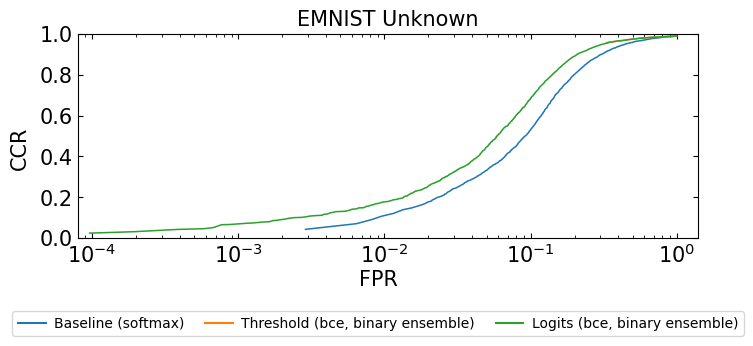

In [67]:
os.chdir("/home/user/kuebler/openset-imagenet-comparison")
pdf = PdfPages(filename=args["output_path"] + "/evaluation_metrics.pdf")
scores, ground_truths = load_scores(args)
plot_OSCR(args, scores, ground_truths)
pdf.savefig(bbox_inches='tight', pad_inches = 0)
pdf.close()